<a href="https://colab.research.google.com/github/deb-kit2/denoise_images/blob/main/doc_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, output
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/denoise")

output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

%matplotlib inline

##helpers

In [3]:
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array

##loading data

In [4]:
path = '/content/drive/My Drive/Colab Notebooks/denoise/'

In [5]:
dirty_names = os.listdir(path + 'in')
clean_names = os.listdir(path + 'out')

In [6]:
from tqdm import tqdm
import numpy as np

dirty = []
clean = []

for f in tqdm(dirty_names):
    t = load_img(path + '/in/' + f, grayscale = True, target_size = (1000, 688))
    t = img_to_array(t).astype('float32')/255.0
    dirty.append(t)

for f in tqdm(clean_names):
    t = load_img(path + '/out/' + f, grayscale = True, target_size = (1000, 688))
    t = img_to_array(t).astype('float32')/255.0
    clean.append(t)

dirty = np.array(dirty)
clean = np.array(clean)

output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')

  0%|          | 0/315 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 315/315 [02:12<00:00,  2.38it/s]


In [7]:
print(dirty.shape)
print(clean.shape)

(315, 1000, 688, 1)
(315, 1000, 688, 1)


In [8]:
xtrain, xval, ytrain, yval = train_test_split(dirty, clean, test_size = 0.15)

In [9]:
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(267, 1000, 688, 1)
(267, 1000, 688, 1)
(48, 1000, 688, 1)
(48, 1000, 688, 1)


##modelling

In [11]:
def model():
    input_layer = Input(shape = (1000, 688, 1))

    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)
    ######################################################new lines
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    #
    x = Dropout(0.3)(x)
    #
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    ###############################################################
    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    #x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)
    model = Model(inputs = [input_layer], outputs = [output_layer])
    model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['mae'])

    return model


model = model()
#model.summary()

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 688, 1)]    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1000, 688, 64)     640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1000, 688, 128)    73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 688, 128)    512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 500, 344, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 344, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 500, 344, 256)    

In [15]:
callback1 = EarlyStopping(monitor = 'loss', patience = 30)
callback2 = ReduceLROnPlateau('val_loss', 0.6, 12, 1)
history = model.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 300, batch_size = 2, verbose = 1, callbacks = [callback1, callback2])

Epoch 1/300
134/134 [==============================] - 92s 683ms/step - loss: 0.0562 - mae: 0.1363 - val_loss: 0.0313 - val_mae: 0.0574
Epoch 2/300
134/134 [==============================] - 89s 663ms/step - loss: 0.0293 - mae: 0.0672 - val_loss: 0.0295 - val_mae: 0.0486
Epoch 3/300
134/134 [==============================] - 89s 662ms/step - loss: 0.0264 - mae: 0.0605 - val_loss: 0.0293 - val_mae: 0.0539
Epoch 4/300
134/134 [==============================] - 89s 662ms/step - loss: 0.0264 - mae: 0.0603 - val_loss: 0.0292 - val_mae: 0.0571
Epoch 5/300
134/134 [==============================] - 89s 662ms/step - loss: 0.0264 - mae: 0.0601 - val_loss: 0.0292 - val_mae: 0.0585
Epoch 6/300
134/134 [==============================] - 89s 663ms/step - loss: 0.0264 - mae: 0.0601 - val_loss: 0.0292 - val_mae: 0.0589
Epoch 7/300
134/134 [==============================] - 89s 662ms/step - loss: 0.0264 - mae: 0.0587 - val_loss: 0.0291 - val_mae: 0.0627
Epoch 8/300
134/134 [===========================

KeyboardInterrupt: ignored

In [16]:
import matplotlib.pyplot as plt

epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

NameError: ignored

In [17]:
model.save("layerEx_resLow.h5")

##test with 2 images

In [18]:
test_names = os.listdir("/content/")
test = []

for f in tqdm(test_names):
    if(f.endswith('.jpg')):
        t = load_img("/content/" + f, grayscale = True, target_size = (1000, 688))
        t = img_to_array(t).astype('float32')/255.0
        test.append(t)

test = np.array(test)
test.shape

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 5/5 [00:00<00:00, 99.06it/s]


(2, 1000, 688, 1)

In [19]:
result = model.predict(test)

In [20]:
result.shape

(2, 1000, 688, 1)

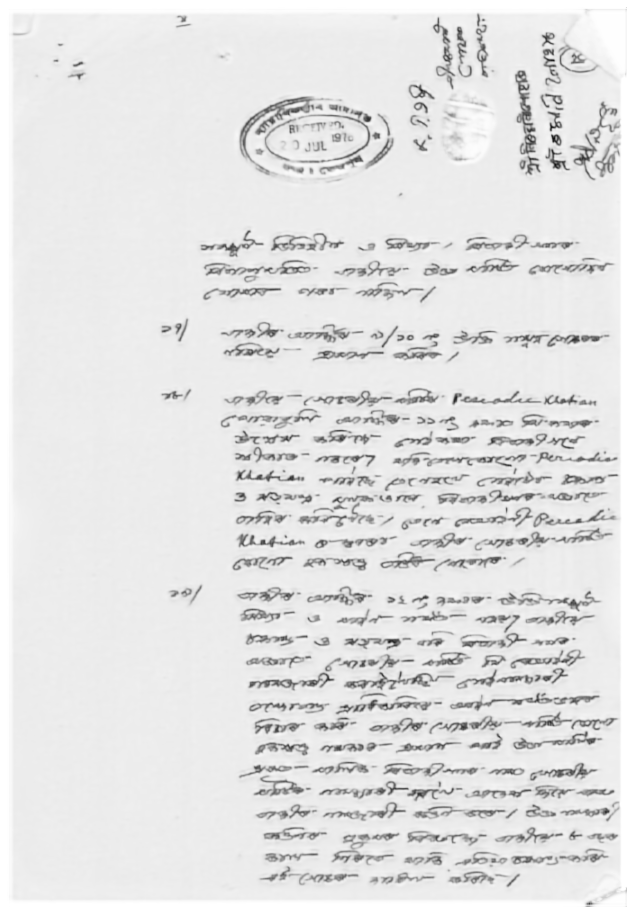

In [21]:
def display_image_in_actual_size(im_data):

    dpi = 80
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data[:,:,0], cmap='gray')

    plt.show()

display_image_in_actual_size(result[0])

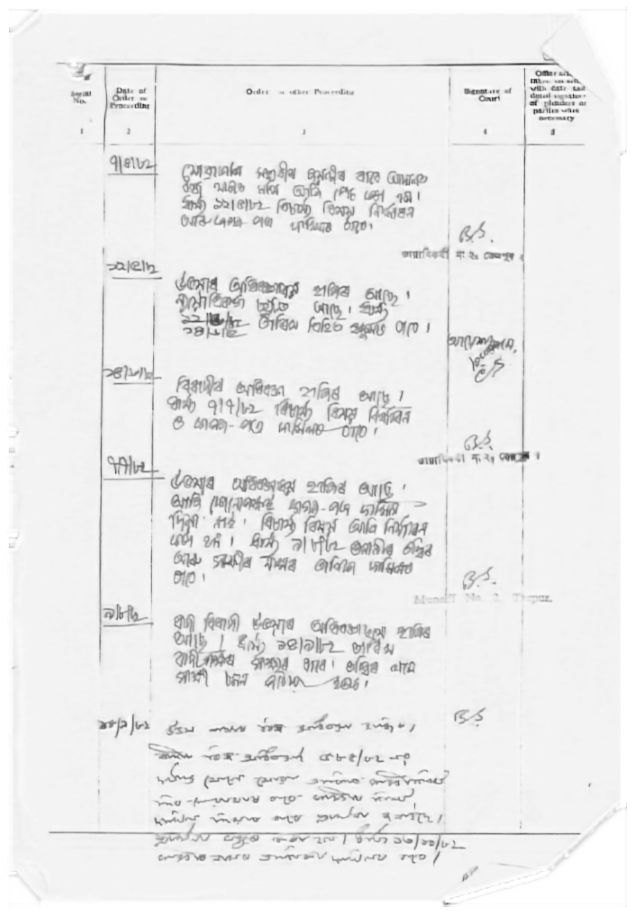

In [22]:
display_image_in_actual_size(result[1])

In [24]:
imsave("res1.jpg", result[1][:,:,0])